# Importing useful packages and libraries

In [0]:
import numpy as np
import pdb
import matplotlib.pyplot as plt
import pandas  as pd
from sklearn.preprocessing import  scale
import seaborn as sns
import cv2
import os
from copy import deepcopy
from math import ceil

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
s_directory = "drive/My Drive/Colab Notebooks/prime_project"

def serialize(obj, filename):
  outfile = open(filename,'wb')
  pickle.dump(obj,outfile)
  outfile.close()

def deserialize(filename):
  infile = open(filename,'rb')
  obj = pickle.load(infile)
  infile.close()
  return obj

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Preliminary EDA

In [0]:
!unzip -q The\ BeeImage\ Dataset\ from\ Kaggle.zip
root_path = './'
directory =  root_path+"/kaggle/bee_imgs/"

We the read the *.csv* file containing metadata about The BeeImage Dataset.

In [0]:
df = pd.read_csv(root_path+"/kaggle/bee_data.csv")
n_tot = df['file'].count()
print("Total images in the dataset: {}".format(n_tot))
df.head()

Total images in the dataset: 5172


,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


For the purposes of the current work, we are only interested in associating each bee to the proper subspecies. For this reason, we are going to discard the images representing bees whose subspecies is unknown.

Images left: 4744
Images lost: 8.275328692962105%
Distinct values of subspecies = 6



Text(0.5, 0, 'Frequency')

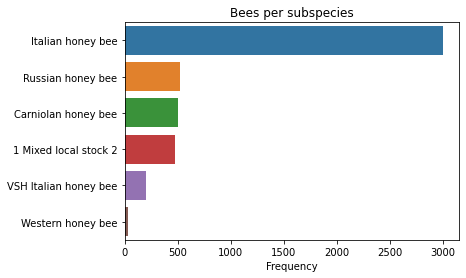

In [0]:
df = df[df['subspecies'] != '-1'] # remove images for which we do not have the class label
print("Images left: {}\nImages lost: {}%".format(df['file'].count(), 100-df['file'].count()/n_tot*100))
print("Distinct values of subspecies = {}\n".format(df["subspecies"].nunique()))
# print("Counting the distinct values of subspecies:\n{}".format(df["subspecies"].value_counts()))

subspecies_counts = df["subspecies"].value_counts()
plt.title("Bees per subspecies")
g = sns.barplot(x = subspecies_counts, y = subspecies_counts.index)
g.set_xlabel("Frequency")

# Loading images and pre-processing

In [0]:
def get_image_data(directory,files):
    '''Returns np.ndarray of images read from the image data directory'''
    # IMAGE_FILE_ROOT = '../data/bee_imgs/' 
    return np.asanyarray([imageio.imread("{}{}".format(directory, file)) for file in files])

def load_images(directory, files):
    '''Load images from disk'''
    X = []
    for img_name in files:
        img = cv2.imread(directory + img_name, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        img = np.array(img)
        X.append(img)
    X = np.array(X)
    return X

def show_image_shapes(images,n):
    '''Print the shape of n images randomly chosen'''
    for i in range(n):
        r = np.random.randint(low=0, high=len(images))
        print("image number {} has shape = {}".format(r, images[r].shape))

def show_image(image, ax = plt, title = None, show_size = False):
    '''Plots a given np.array image'''
    ax.imshow(image)
    if title:
        if ax == plt:
            plt.title(title)
        else:
            ax.set_title(title)
    if not show_size:
        ax.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)
        
def show_images(images, titles = None, show_size = False):
    '''Plots many images from the given list of np.array images'''
    cols = 4
    f, ax = plt.subplots(nrows=int(np.ceil(len(images)/cols)),ncols=cols, figsize=(14,5))
    ax = ax.flatten()
    for i, image in enumerate(images):
        if titles:
            show_image(image, ax = ax[i], title = titles[i], show_size = show_size)
        else:
            show_image(image, ax = ax[i], title = None, show_size = show_size)
    plt.show()       

Firstly we load the images.

In [0]:
%time images = load_images(directory, df.file.values)
# %time images = get_image_data(directory,df.file.values)

CPU times: user 1.09 s, sys: 131 ms, total: 1.22 s
Wall time: 1.27 s


Then we display some images and their shape.

In [0]:
show_image_shapes(images,5)

image number 4707 has shape = (41, 45, 3)
image number 3943 has shape = (49, 46, 3)
image number 2656 has shape = (35, 59, 3)
image number 2808 has shape = (44, 61, 3)
image number 1927 has shape = (37, 62, 3)


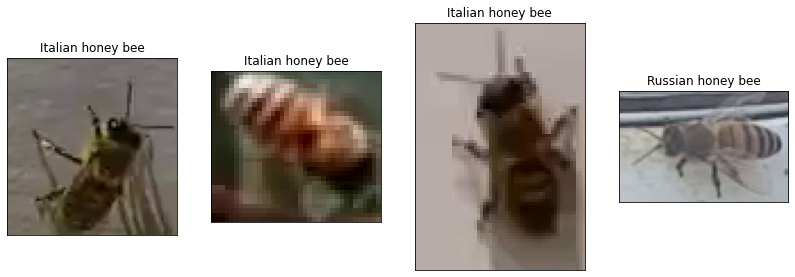

In [0]:
show_images(images[::1200],list(df["subspecies"][::1200]))

As we can see from previous outputs, images have different shapes. However, in order to train a CNN, all input images should have the same shape. Therefore, we need to reshape them somehow. Basically we have the following possibilities:

 * reshape all images to **the smallest image size**: applying this technique will lead to huge loss in data quality, which is not acceptable in our case since images already have a very low quality;

 * reshape all images to **the highest image size**: this technique may lead to noisy images and the network may not learn anything at all.


Here we propose an approch who finds **the most frequent image shape** and uses it to reshape the other images. The intuition behind this technique is that it may allow to reshape only few images and therefore reserve data quality for most of them.

Furthermore, the original aspect ratio may not fit into the one forced by the new shape. Eventually, reshaping can be carried out in two different ways:

 * by **shrinking and stretching** the original image up to the requested shape;

 * by **preserving the original aspect ratio** by adding black pixels as padding.

In the following we will implement both techniques to test which is the best one.

## Finding the most frequent image shape

In [0]:
def get_images_wh(images):
    '''Returns a tuple of lists, representing the widths and heights of the given images, respectively.'''
    widths = []
    heights = []
    for image in images:
        h, w, rbg = image.shape
        widths.append(w)
        heights.append(h)
    return (widths, heights)

def get_best_average(dist, cutoff = .5):
    '''Returns an integer of the average from the given distribution above the cutoff.
    '''
    # requires single peak normal-like distribution
    hist, bin_edges = np.histogram(dist, bins = 25);
    total_hist = sum(hist)
    
    # associating proportion of hist with bin_edges
    hist_edges = [(vals[0]/total_hist,vals[1]) for vals in zip(hist, bin_edges)]
    
    # sorting by proportions (assumes normal-like dist such that high freq. bins are close together)
    hist_edges.sort(key = lambda x: x[0])
    lefts = []
    
    # add highest freq. bins to list up to cutoff % of total
    while cutoff > 0:
        vals = hist_edges.pop()
        cutoff -= vals[0]
        lefts.append(vals[1])
        
    # determining leftmost and rightmost range, then returning average
    diff = np.abs(np.diff(lefts)[0]) # same diff b/c of bins
    leftmost = min(lefts)
    rightmost = max(lefts) + diff
    return int(np.round(np.mean([rightmost,leftmost])))

In [0]:
wh = get_images_wh(images)

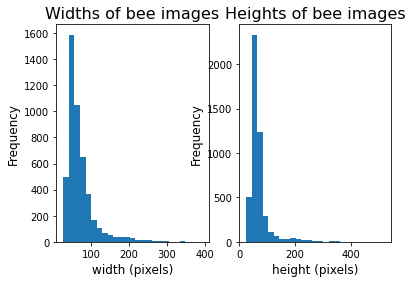

In [0]:
size = 12
plt.subplot(1,2,1)
plt.title("Widths of bee images", fontsize = size * 4/3, pad = size/2)
plt.ylabel("Frequency", size = size)
plt.xlabel("width (pixels)", size = size)
plt.hist(wh[0], bins = 25);

plt.subplot(1,2,2)
plt.title("Heights of bee images", fontsize = size * 4/3, pad = size/2)
plt.ylabel("Frequency", size = size)
plt.xlabel("height (pixels)", size = size)
plt.hist(wh[1], bins = 25);

We can notice that the distribution of **width** and **height** of images is very biased towards small values. So we will consider only the $50 \%$ most frequent values for **weigth** and **height**, then we will average them to determine the shape of our input images. This technique will allow to alter the least majority of the data.

*NOTE*: we could have defined **width** and **height** as the average over the **width** and shape of all the images. However, this technique should have not been efficient since the distrinution of the two variables is mainly concentrated around the interval $[48, 78]$.

In [0]:
ideal_width, ideal_height = get_best_average(wh[0]), get_best_average(wh[1])
print("the ideal height and width for our images are ",ideal_height,ideal_width) 

the ideal height and width for our images are  64 56


## Resizing the images

In order to resize the images, we can use the package *opencv* which already implement some useful functions to resize an image. 

In [0]:
def resize_images_stretching(images,new_shape):
    """
    resize the entire data set of images
        @input
            - images: ndarray of shape=(n_images,) where each image is of shape (height,width,n_channel)
            - new_shape : a tuple (height,width)
        @returns:
            an ndarray representing the reshaped image dataset
    """
    size = (new_shape[1], new_shape[0]) # because dsize should be (width,height)
    reshaped_images = []
    for image in images:
        image = cv2.resize(src=image, dsize= size, interpolation = cv2.INTER_AREA)
        reshaped_images.append(image)  
    return np.asarray(reshaped_images)

def resize_images_padding(images, desired_size=64):
    """
    resize the entire data set of images with black padding
    in order to the aspect ratio
        @input
            - images: ndarray of shape=(n_images,) where each image is of shape (height,width,n_channel)
            - desired_size : an int
        @returns:
            an ndarray representing the reshaped image dataset
    """
    reshaped_images = []
    color = [0, 0, 0]

    for img in images:
        old_size = img.shape[:2]
        ratio = float(desired_size)/max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])

        img = cv2.resize(img, (new_size[1], new_size[0]))

        delta_w = desired_size - new_size[1]
        delta_h = desired_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        
        new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
        reshaped_images.append(new_img)

    return np.asarray(reshaped_images)

def dataset_statistics(images):
    print("The total number of images is :",len(images))
    s = images[0].shape
    uniform = True
    for i in images:
        if i.shape != s:
            uniform = False
    if uniform:
        print("All images have the same shape which is ",s)
    else:
        print("WARNING: all images does not have the same shape,therefore it's not possible to train a CNN")     

In [0]:
black_padding = False

def reshape_stretching_padding(images, ideal_height, ideal_width, nb_channels, black_padding):
  """reshape the image data set using the dimenssions passed as argument
  @input:
   -images: ndarray of shape(n,hiegth,width,channels) representing the data set of images
   -ideal_height: integer representing the height
   -ideal_widht: integer representing the width
   -nb_channels: integer representing the number of channels
   -black_padding: boolean indicating wether to reshape using blackpadding or stretching

  @return:
  an ndarray of shape (n,ideal_heigth,ideal_width,nb_channels) representing the reshaped images 
  """
  if black_padding:
    new_shape = (ideal_height,ideal_height, 3)
    reshaped_images = resize_images_padding(images,ideal_height)
  else:
    new_shape = (ideal_height,ideal_width, 3)
    reshaped_images = resize_images_stretching(images,new_shape)
  return reshaped_images,new_shape

reshaped_images,new_shape = reshape_stretching_padding(images, ideal_height, ideal_width, 3, black_padding)

We define a function to normalize the images in the interval $[0, 255]$. This might improve the accuracy.

In [0]:
def normalize_images(X):
    res = []
    for i in range(X.shape[0]):
        res.append(cv2.normalize(X[i], 0, 255, norm_type=cv2.NORM_MINMAX))
    return np.array(res)

The total number of images is : 4744
All images have the same shape which is  (64, 56, 3)


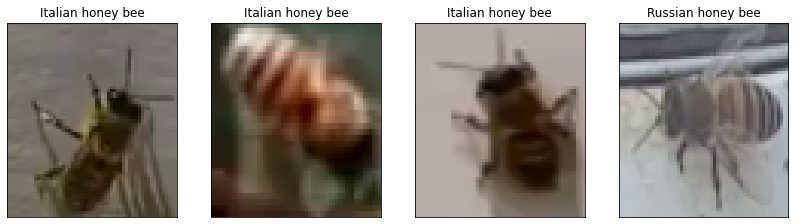

In [0]:
# reshaped_images = normalize_images(reshaped_images) # it's strange that normalizing mess the training process. we need to understand why ??
dataset_statistics(reshaped_images)
show_images(reshaped_images[::1200],list(df["subspecies"][::1200]))

We also need to encode the labels with integer values.

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

le = LabelEncoder()
labels = df.subspecies.values
encoded_labels = le.fit_transform(labels)
y = to_categorical(encoded_labels)

Using TensorFlow backend.


Now we can finally split the data for training and testing purposes.

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(reshaped_images, y, test_size=0.2, random_state=2020)

In [0]:
print("X_train.shape = {}\nX_test.shape = {}\ny_train.shape = {}\ny_test.shape ={}"
      .format(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape))

X_train.shape = (3795, 64, 56, 3)
X_test.shape = (949, 64, 56, 3)
y_train.shape = (3795, 6)
y_test.shape =(949, 6)


# Building the CNN with Keras

We might consider the possibility of starting from a given network architecture already trained on a well-known dataset (e.g. *ImageNet*). In this case, the guidelines for sketching out the network archtechture would be the following:

1. **The new dataset is small and similar to original dataset**: since the amount of data is small, it is not a good idea to fine-tune the CNN due to overfitting concerns; since data are similar to the original ones, we expect higher-level features in the CNN to be relevant to this dataset as well; hence, the best idea might be to train a linear classifier on the CNN code.

2. **The new dataset is large and similar to the original dataset**: since we have more data, we might have higher confidence that we won’t overfit if we were to try to fine-tune through the full network.

3. **The new dataset is small but very different from the original dataset**: since the amount of data is small, it is likely best to only train a linear classifier; since the dataset is very different from the original one, it might not be best to train the classifier form the top of the network, which contains more dataset-specific features; instead, it might work better to train the SVM classifier from activations somewhere earlier in the network.

4. **The new dataset is large and very different from the original dataset**: since the dataset is very large, we may expect that we can afford to train a CNN from scratch; however, in practice it is very often still beneficial to initialize with weights from a pretrained model; in this case, we would have enough data and confidence to fine-tune through the entire network.

In our case, since we have a small dataset and there is no CNN architecture trained on similar classification tasks, we decided to define our onw architecture.

In [0]:
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras import optimizers
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
print(keras.__version__)

2.3.1


In the following we will use image generators in order to load data. Data generators are on-the-fly image transformers and are the recommended way of providing image data to models in Keras. They let you work with on-disk image data too large to fit all at once in-memory. They allow also to preprocess the images the model sees with random image transformations and standardizations, a key technique for improving model performance. For more see https://keras.io/preprocessing/image/.

In [0]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    # rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_datagen.fit(X_train)

In [0]:
img_rows, img_cols, nb_channels = new_shape
input_shape = (img_rows, img_cols, nb_channels)
nb_classes = Y_train.shape[1]

nb_filters = 32
kernel_size = (3, 3)
pool_size = (2, 2)

model = Sequential()
model.add(Conv2D(
    filters = nb_filters, 
    kernel_size = kernel_size, 
    activation='relu',
    padding= "same",
    kernel_initializer = "glorot_normal", 
    input_shape = input_shape,
    name = "conv_1"
))
model.add(Conv2D(
    filters = nb_filters,
    kernel_size = kernel_size,
    activation='relu',
    padding ="same",
    kernel_initializer = "glorot_normal",
    name='conv_2'
))
model.add(MaxPooling2D((2, 2), name="max_pool_2"))
model.add(Conv2D(
    filters = nb_filters,
    kernel_size = kernel_size,
    activation='relu',
    padding ="same",
    kernel_initializer= "glorot_normal",
    name='conv_3'
))
model.add(MaxPooling2D((2, 2), padding="same", name = "max_pool_3"))
model.add(Flatten())
model.add(Dense(
    nb_classes,
    activation='softmax',
    kernel_initializer="glorot_normal",
    name='dense'
))

Now we compile the model, define the loss and the optimizer.

In [0]:
learning_rate = 0.001
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=True, mode='min', restore_best_weights=True)

Finally we define a function to plot the accuracy and the loss over epochs and another one to plot the confusion matrix.

In [0]:
def plot_acc_loss(history, separate_plots = True):
    """
    plot the accuracy and the loss over epchos
        @input:
            - acc : array of shape=(n_epochs,) representing the accuracy of the model during training over epochs
            - loss: array of shape=(n_epochs,) representing the loss of the model during training
    """
    if separate_plots == True:
        plt.plot(history['accuracy'], 'g', label="train_acc")
        plt.plot(history['loss'], 'r', label="train_loss")
        plt.xlabel("epoch")
        plt.ylabel("metric")
        plt.legend()
        plt.show()

        plt.plot(history['val_accuracy'], 'g', label="val_acc")
        plt.plot(history['val_loss'], 'r', label="val_loss")
        plt.xlabel("epoch")
        plt.ylabel("metric")
        plt.legend()
        plt.show()
    else:
        plt.plot(history['acc'], 'g', label="train_acc")
        plt.plot(history['loss'], 'r', label="train_loss")
        plt.plot(history['val_acc'], 'g', label="val_acc")
        plt.plot(history['val_loss'], 'r', label="val_loss")
        plt.xlabel("epoch")
        plt.ylabel("metric")
        plt.legend()
        plt.show()

In [0]:
def plot_confusion_matrix(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    Y_pred_classes = np.argmax(Y_pred, axis = 1)
    Y_true = np.argmax(Y_test, axis = 1)
    confusionMatrix = confusion_matrix(Y_true, Y_pred_classes)
    f,ax=plt.subplots(figsize=(10,10))
    sns.heatmap(confusionMatrix, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="black", fmt='.0f', ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

We get the summary of the model so that we can have an idea of the architechture and the weigths that will be trained.

In [0]:
'''
the number of trainable of parameters at each layers is equal to
the total number of weight of all the filters at each layer;
in this case 3*3*(size of each filter) *
    3*(depth of each filter) *
    32*(total number of filters at the first layer) +
    32(each filter has a bias) = 896
'''
model.summary()
model_copy = deepcopy(model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 64, 56, 32)        896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 64, 56, 32)        9248      
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 32, 28, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 32, 28, 32)        9248      
_________________________________________________________________
max_pool_3 (MaxPooling2D)    (None, 16, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7168)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                

Finally we train the model.

In [0]:
n_epochs = 100
batch_size = 128

model = deepcopy(model_copy)
history = model.fit(
    train_datagen.flow(x= X_train, y = Y_train, batch_size=batch_size, shuffle=True),
    validation_data = (X_test, Y_test),
    callbacks=[early_stopping],
    steps_per_epoch=ceil(len(X_train)/ batch_size),
    epochs=n_epochs,
    verbose = 1
)

Epoch 1/100
30/30 [==============================] - 5s 181ms/step - loss: 9.9673 - accuracy: 0.5631 - val_loss: 0.7710 - val_accuracy: 0.6786
Epoch 2/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6192 - accuracy: 0.7787 - val_loss: 0.4648 - val_accuracy: 0.8272
Epoch 3/100
30/30 [==============================] - 5s 166ms/step - loss: 0.4669 - accuracy: 0.8324 - val_loss: 0.4026 - val_accuracy: 0.8388
Epoch 4/100
30/30 [==============================] - 5s 164ms/step - loss: 0.4589 - accuracy: 0.8190 - val_loss: 0.4060 - val_accuracy: 0.8335
Epoch 5/100
30/30 [==============================] - 5s 161ms/step - loss: 0.4157 - accuracy: 0.8321 - val_loss: 0.4258 - val_accuracy: 0.8177
Epoch 6/100
30/30 [==============================] - 5s 162ms/step - loss: 0.3840 - accuracy: 0.8350 - val_loss: 0.3965 - val_accuracy: 0.8346
Epoch 7/100
30/30 [==============================] - 5s 158ms/step - loss: 0.3286 - accuracy: 0.8667 - val_loss: 0.2981 - val_accuracy: 0.8767

We can now evaluate the performances of the model on test data, plot accuracy and the loss over epochs during training.

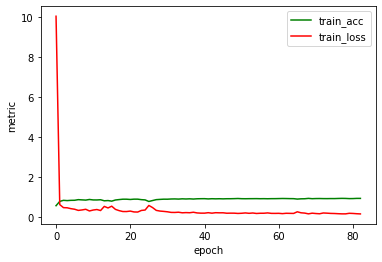

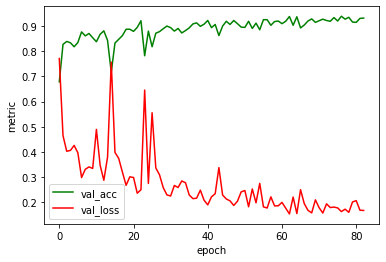

In [0]:
plot_acc_loss(history.history)

Plotting the confusion matrix  might be useful in order to evaluate the overall performance of the network.

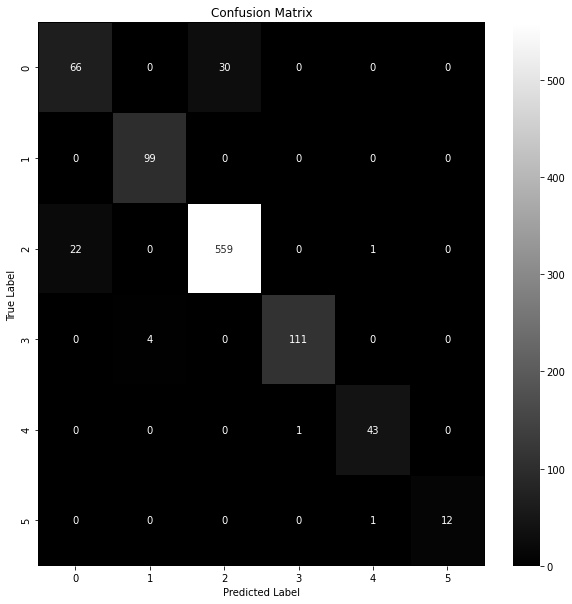

In [0]:
plot_confusion_matrix(model, X_test, Y_test)

<font color="grey">As first interpretation, we can notice that the bias in class we had in the training data is found in output too as the model learns very well how to predict **Italian honey bee** since it's the dominant class in the dataset. Moreover, the classifer tends to classify rare classes as belonging to **Italian honey bee class** as we can see from column 2 of the confusion matrix.</font>

The interpretation above is not true anymore. The problem that was affecting the learning process was the **scaling factor** in the *ImageDataGenerator*. Indeed, the confusion matrix undoubtedly shows that the classifier performs quite well on all the classes as it has a very low misprediction rate.

# Targeting data scarcity with focused data augmentation

In the following we will consciously apply data augementation in order to take into account the actual data distribution. We already know that the dataset is strongly biased towards **Italian honey bee** class. Therefore, we might want to assign **weights** to each class during training, so that we end up paying more attention to rare classes. We can use 2 completely equivalent stategies:


*   passing a dictionary associating a given weight to each class to *fit_generator* function, so that it can compute the loss accordingly;
*   generating weighted samples by means of *ImageDataGenerator* itelsef, so that it can output batches of *(inputs, targets, sample_weights)*.


From an implementative point of view, the difference is that first method uses weights for each class while the second one needs weights for each sample in the training dataset. However, both method are practically the same.

In [0]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.unique(encoded_labels), encoded_labels)
class_weight_dict = dict(enumerate(class_weights))
sample_weights = class_weight.compute_sample_weight('balanced', encoded_labels)
print("class_weights : {}\nclass_weights.shape: {}\nclass_weights_dict : {}\nsample_weights.shape : {}\ny.shape : {}"
        .format(class_weights, class_weights.shape, class_weight_dict, sample_weights.shape, y.shape))

class_weights : [ 1.67514124  1.57817698  0.26285461  1.50031626  3.97319933 21.36936937]
class_weights.shape: (6,)
class_weights_dict : {0: 1.6751412429378532, 1: 1.5781769793745841, 2: 0.262854609929078, 3: 1.5003162555344718, 4: 3.9731993299832498, 5: 21.36936936936937}
sample_weights.shape : (4744,)
y.shape : (4744, 6)


In [0]:
X_train, X_test, Y_train, Y_test, sample_weights_train, sample_weights_test = train_test_split(reshaped_images, y, sample_weights, test_size=0.2, random_state=2020)
print("X_train.shape = {}\nX_test.shape = {}\ny_train.shape = {}\ny_test.shape = {}\nsample_weights_train.shape = {}\nsample_weights_test.shape = {}"
      .format(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape,sample_weights_train.shape, sample_weights_test.shape))
train_datagen.fit(X_train)

X_train.shape = (3795, 64, 56, 3)
X_test.shape = (949, 64, 56, 3)
y_train.shape = (3795, 6)
y_test.shape = (949, 6)
sample_weights_train.shape = (3795,)
sample_weights_test.shape = (949,)


Now that we have both *class_weights* and *sample_weights* we can train the model again taking into account the actual classes' distribution. It's possible to switch between the first and the second implementation by means of *weighted_data_augmentation* flag.

In [0]:
n_epochs = 100
batch_size = 128

model = deepcopy(model_copy)
weighted_data_augmentation = True
if not weighted_data_augmentation:
    history = model.fit_generator(
        train_datagen.flow(x = X_train, y = Y_train, batch_size=batch_size, shuffle=True),
        validation_data = (X_test, Y_test, sample_weights_test),
        steps_per_epoch=ceil(len(X_train)/ batch_size),
        callbacks=[early_stopping],
        epochs=n_epochs,
        class_weight = class_weight_dict,
        verbose = 1
    )
else:
    history = model.fit_generator(
        train_datagen.flow(x = X_train, y = Y_train, batch_size=batch_size, shuffle=True, sample_weight=sample_weights_train),
        validation_data = (X_test, Y_test, sample_weights_test),
        steps_per_epoch=ceil(len(X_train)/ batch_size),
        callbacks=[early_stopping],
        epochs=n_epochs,
        verbose = 1
    )

Epoch 1/100
30/30 [==============================] - 9s 294ms/step - loss: 27.9420 - accuracy: 0.2735 - val_loss: 1.6231 - val_accuracy: 0.5269
Epoch 2/100
30/30 [==============================] - 3s 116ms/step - loss: 1.1299 - accuracy: 0.4414 - val_loss: 0.8521 - val_accuracy: 0.6554
Epoch 3/100
30/30 [==============================] - 4s 118ms/step - loss: 0.6622 - accuracy: 0.6124 - val_loss: 0.6372 - val_accuracy: 0.6470
Epoch 4/100
30/30 [==============================] - 3s 116ms/step - loss: 0.5903 - accuracy: 0.6311 - val_loss: 0.5624 - val_accuracy: 0.6681
Epoch 5/100
30/30 [==============================] - 4s 117ms/step - loss: 0.5081 - accuracy: 0.6145 - val_loss: 0.5282 - val_accuracy: 0.6691
Epoch 6/100
30/30 [==============================] - 4s 119ms/step - loss: 0.5047 - accuracy: 0.6603 - val_loss: 0.4591 - val_accuracy: 0.7218
Epoch 7/100
30/30 [==============================] - 4s 117ms/step - loss: 0.5763 - accuracy: 0.6377 - val_loss: 0.4720 - val_accuracy: 0.720

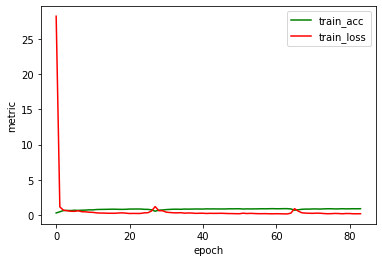

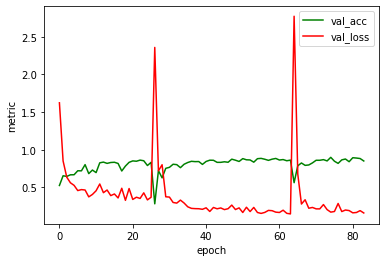

In [0]:
plot_acc_loss(history.history)

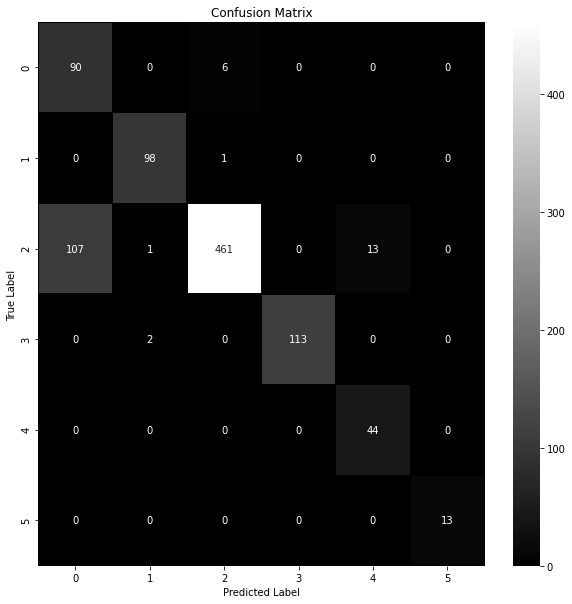

In [0]:
plot_confusion_matrix(model, X_test, Y_test)

<font color="grey">Eventually, we notice that performances are not improved at all! Furthermore, the training got quite unstable and accuracy measure on training dataset seems to saturate. This behavior can be explained as excessive data shortage that cannot be filled by any data augmentation, not even a properly measured and weighted one.</font>

The interpretation above is not true anymore due to the **scaling factor** issue. The model seems to perform quite well on the minority classes because it has a low misprediction ratio as seen in the previous confusion matrix: in particular the misprediction for minority classes was higher. However, in the latter the overall accuracy is smaller than the initial one.

Furthermore, we may notice that quite a lot of images belonging to **Italian honey bee** class are predicted as **1 Mixed local stock 2**. We are not able to recover any information about the actual meaning of this label, but apparently it is something mixed! If this is the case, we might interpret this result as not an actual mistake! However, this might end up being a loss of information, as we are essentially classifying some images as **1 Mixed local stock 2** (i.e. unknown, ndr) even if we actually know the class! *We will address this issue later.*

# Removing some bees to even the distribution

<font color="grey">As we have seen in the previous section, data augmentation itself cannot face drammatic disparities in classes distribution. Therefore, we might embrace a different approach.</font>

<font color="grey">In the following, we are going to directly manage two critical classes from the dataset:


*   **Western honey bee** which has very few images that might be completely discarded;
*   **Italian honey bee** which is strongly dominant and can be shrunk.</font>


The comment above is not totally valid anymore due to the **scaling factor** issue. Indeed, the current CNN is impressively good at classifying images labeled as **Western honey bee**. Even if performances might not be really good in an actual deployment scenario, in the next we are going to keep open the possibility of preserving this images in the dataset as they seems not to affect the overall accuracy.

Here are some numbers describing these issues.

In [0]:
print("Percentage of 'Western honey bee' images : {} %\nPercentage of 'Italian honey bee' images : {} %"
    .format(len(np.where(labels == "Western honey bee")[0])/len(labels) * 100, 
            len(np.where(labels == "Italian honey bee")[0])/len(labels) * 100))

Percentage of 'Western honey bee' images : 0.7799325463743676 %
Percentage of 'Italian honey bee' images : 63.40640809443507 %


Removing **Western honey bee** class can be done immediately.

In [0]:
include_western = True

if not include_western:
    reduced_reshaped_images = reshaped_images[labels != "Western honey bee"]
    reduced_labels = labels[labels != "Western honey bee"]
    print("Original dataset shape : {}\nReduced dataset shape : {}"
        .format(reshaped_images.shape, reduced_reshaped_images.shape))
else:
    reduced_reshaped_images = reshaped_images
    reduced_labels = labels

Secondly, we want to randomly select a restricted amount of images belonging to **Italian honey bee** class. For instance, we can keep an amount of **Italian honey bee** images equal to the ones belonging to **Russian honey bee** class, that is the secont most frequent class in the dataset.

In [0]:
random_generator = np.random.RandomState(seed = 2020)

russian_number = len(np.where(reduced_labels == "Russian honey bee")[0])
print("Number of 'Russian honey bee' images : {}".format(russian_number))

rescued_italian_index = np.where(reduced_labels == "Italian honey bee")[0]
print("Total number of 'Italian honey bee' images before reducing : {}".format(len(rescued_italian_index)))
rescued_italian_index = random_generator.choice(rescued_italian_index, size=np.minimum(russian_number,len(rescued_italian_index)), replace=False)
rescued_italian = reduced_reshaped_images[rescued_italian_index]

reduced_reshaped_images = reduced_reshaped_images[reduced_labels != "Italian honey bee"]
reduced_reshaped_images = np.concatenate((reduced_reshaped_images, rescued_italian), axis=0)
reduced_labels = reduced_labels[reduced_labels != "Italian honey bee"]
reduced_labels = np.concatenate((reduced_labels, np.array(["Italian honey bee"]*len(rescued_italian))), axis=0)

print("reduced_reshaped_images.shape : {}\nreduced_label.shape : {}\nPercentage of 'Italian honey bee' images in the reduced dataset : {} %"
    .format(reduced_reshaped_images.shape,
            reduced_labels.shape,
            len(np.where(reduced_labels == "Italian honey bee")[0])/len(reduced_labels) * 100))

Number of 'Russian honey bee' images : 527
Total number of 'Italian honey bee' images before reducing : 3008
reduced_reshaped_images.shape : (2263, 64, 56, 3)
reduced_label.shape : (2263,)
Percentage of 'Italian honey bee' images in the reduced dataset : 23.28767123287671 %


We can visualize the result of the previous computations by a bar graph.

Text(0.5, 0, 'Frequency')

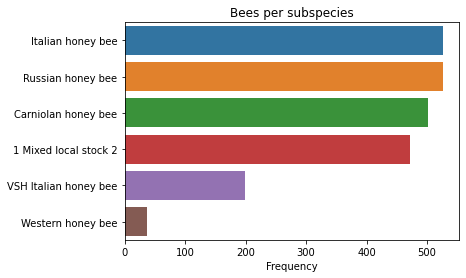

In [0]:
reduced_labels_df = pd.DataFrame(reduced_labels, columns = ['reduced_labels'])
reduced_subspecies_counts = reduced_labels_df['reduced_labels'].value_counts()
plt.title("Bees per subspecies")
g = sns.barplot(x = reduced_subspecies_counts, y = reduced_subspecies_counts.index)
g.set_xlabel("Frequency")

Next, we need to properly encode the reduced set of labels as we did in the first place.

In [0]:
reduced_le = LabelEncoder()
reduced_encoded_labels = reduced_le.fit_transform(reduced_labels)
reduced_y = to_categorical(reduced_encoded_labels)

In [0]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(reduced_encoded_labels), reduced_encoded_labels)
class_weight_dict = dict(enumerate(class_weights))
sample_weights = class_weight.compute_sample_weight('balanced', reduced_encoded_labels)
print("class_weights : {}\nclass_weights.shape: {}\nclass_weights_dict : {}\nsample_weights.shape : {}\ny.shape : {}"
        .format(class_weights, class_weights.shape, class_weight_dict, sample_weights.shape, reduced_y.shape))

class_weights : [ 0.79908192  0.75282768  0.71568627  0.71568627  1.89530988 10.19369369]
class_weights.shape: (6,)
class_weights_dict : {0: 0.7990819209039548, 1: 0.7528276779773786, 2: 0.7156862745098039, 3: 0.7156862745098039, 4: 1.8953098827470687, 5: 10.193693693693694}
sample_weights.shape : (2263,)
y.shape : (2263, 6)


As we can see, now we have $5$ classes (still $6$ if we decided to keep **Western honey bee** images) that are almost uniformly distribuited (except for **VSH Italian honey bee** class). Nonetheless, in the following we are going to use sample weights during data augmentation anyway.

In [0]:
print(reduced_le.classes_) # The index of the class in the array will correspond the encoded label

['1 Mixed local stock 2' 'Carniolan honey bee' 'Italian honey bee'
 'Russian honey bee' 'VSH Italian honey bee' 'Western honey bee']


In [0]:
X_train, X_test, Y_train, Y_test, sample_weights_train, sample_weights_test = train_test_split(reduced_reshaped_images, reduced_y, sample_weights, test_size=0.2, random_state=2020)
print("X_train.shape = {}\nX_test.shape = {}\ny_train.shape = {}\ny_test.shape = {}\nsample_weights_train.shape = {}\nsample_weights_test.shape = {}"
      .format(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape,sample_weights_train.shape, sample_weights_test.shape))

X_train.shape = (1810, 64, 56, 3)
X_test.shape = (453, 64, 56, 3)
y_train.shape = (1810, 6)
y_test.shape = (453, 6)
sample_weights_train.shape = (1810,)
sample_weights_test.shape = (453,)


If we decided to remove **Western honey bee** images, we need to refine CNN's architecture: in particular last **Dense** layer must have $5$ units instead of $6$, as we reduced the number of classes by $1$.

In [0]:
model = deepcopy(model_copy)

if not include_western:
    nb_classes = Y_train.shape[1]

    model.pop()
    model.add(Dense(
        nb_classes,
        activation='softmax',
        kernel_initializer="glorot_uniform",
        name='dense'
    ))
    model.summary()

    learning_rate = 0.001
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(learning_rate),
                  metrics=['accuracy'])

Before training the model, we need to refit *ImageDataGenerator* on the new dataset.

In [0]:
train_datagen.fit(X_train)

In [0]:
n_epochs = 100
batch_size = 128

history = model.fit_generator(
    train_datagen.flow(x = X_train, y = Y_train, batch_size=batch_size, shuffle=True, sample_weight=sample_weights_train),
    validation_data = (X_test, Y_test, sample_weights_test),
    steps_per_epoch=ceil(len(X_train)/ batch_size),
    callbacks=[early_stopping],
    epochs=n_epochs,
    verbose = 1
)

Epoch 1/100
15/15 [==============================] - 2s 164ms/step - loss: 28.5106 - accuracy: 0.2127 - val_loss: 2.1413 - val_accuracy: 0.4614
Epoch 2/100
15/15 [==============================] - 2s 141ms/step - loss: 1.4199 - accuracy: 0.4271 - val_loss: 0.9290 - val_accuracy: 0.6402
Epoch 3/100
15/15 [==============================] - 2s 152ms/step - loss: 0.6313 - accuracy: 0.7099 - val_loss: 0.4610 - val_accuracy: 0.8322
Epoch 4/100
15/15 [==============================] - 2s 146ms/step - loss: 0.3795 - accuracy: 0.8320 - val_loss: 0.3433 - val_accuracy: 0.8543
Epoch 5/100
15/15 [==============================] - 2s 151ms/step - loss: 0.3462 - accuracy: 0.8497 - val_loss: 0.2883 - val_accuracy: 0.9029
Epoch 6/100
15/15 [==============================] - 2s 150ms/step - loss: 0.3132 - accuracy: 0.8707 - val_loss: 0.2634 - val_accuracy: 0.8587
Epoch 7/100
15/15 [==============================] - 2s 150ms/step - loss: 0.3357 - accuracy: 0.8376 - val_loss: 0.3534 - val_accuracy: 0.863

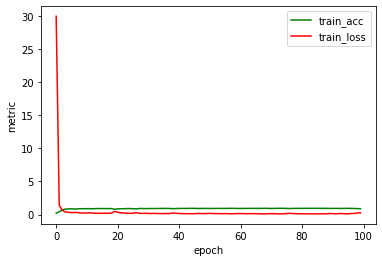

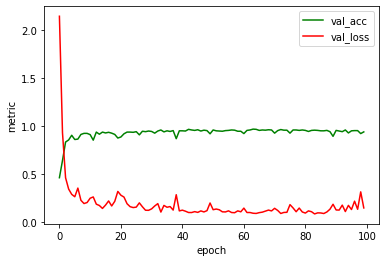

In [0]:
plot_acc_loss(history.history)

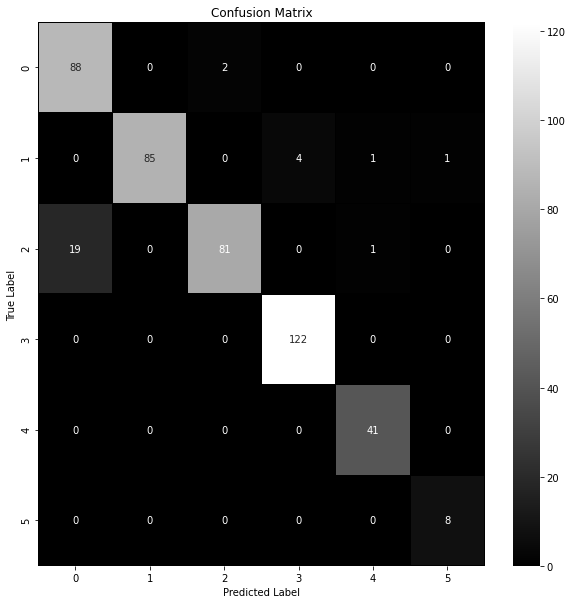

In [0]:
plot_confusion_matrix(model, X_test, Y_test)

<font color="grey">Results are quite bad even with a data distribution that is almost uniform: **Italian honey bee** class is still getting all the prediction! We supposed that the images belonging to this class end up to monopolize the predictions because of some features that result dominant somehow. Therefore, we tried to normalize the dataset, but we obtained exactly the same inconsequential results.</font>

The interpretation above is not true anymore due to the **scaling factor** issue. Currently, the classifier is performing incredibly well on all the classes since they have similar distributions. We can appreciate the quality of the classifier by looking the number of mispredictions for all the classes which is lower than the one obtained with the original dataset.<br>
We might still highlight the misclassification phenomenon for some **Italian honey bee** images, which might further confirm the previous hypothesis.

# Restoring the original dataset but removing ambiguous images

We observed extraordinary performances in the previous classification task trained on a dataset exhibiting (almost) uniform distribution of classes. Anyway, we know that removing data is not a good practice in general, as we are essentially losing knowledge.

Indeed, we notice that loss and accuracy measures could have been improved just as consequence of decreasing the amount of **Italian honey bee** images, which used to matter the most to performances of the model. In particular, we remind that we are still classifying some images as **1 Mixed local stock 2** (i.e. *unknown*, ndr) even if we actually know they are labeled as **Italian honey bee**.

In the following, we are going to analyse this issue in more detail. We start to display some images belonging to **Italian honey bee** class which are actually classified as **1 Mixed local stock 2** (first row below, i.e. **FP 1 Mixed local stock 2**) and relate them to actual **Italian honey bee** images (second row below, i.e. **TP Italian honey bee**).

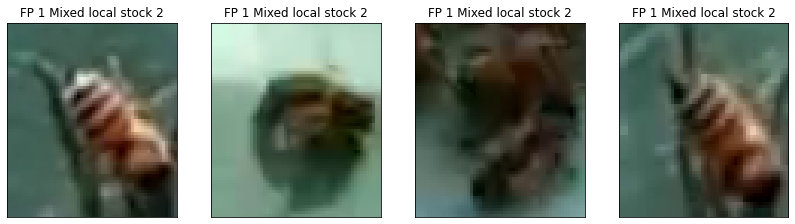

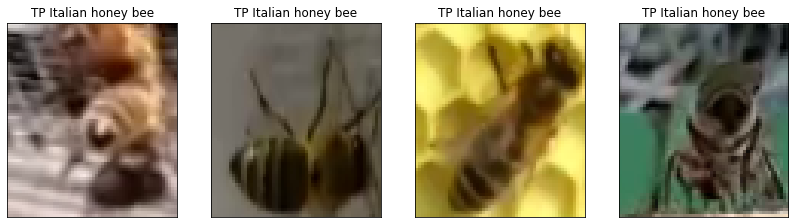

In [0]:
'''
You don't need to run this cell of code: it has only descriptive purposes!
If you want to run this you need "model", that is the output of the training happening in "Removing some bees to even the distribution" section.
'''
predictions = model.predict_classes(X_test)
Y_test_label = np.argmax(Y_test, axis=1)
mispredicted_italian = X_test[(predictions == 0) & (Y_test_label == 2)]
true_italian = X_test[(predictions != 0) & (Y_test_label == 2)]
show_images(mispredicted_italian[:4], ["FP 1 Mixed local stock 2"]*4)
show_images(true_italian[:4], ["TP Italian honey bee"]*4)

By visual comparisons, we might just confirm our suspicions as **FP 1 Mixed local stock 2** images look very similary to actual **Italian honey bee**. Therefore, we may inspect the behaviour of a CNN trained on a dataset completely deprived of **1 Mixed local stock 2** images. Net of previous results, we don't think that the unbalanced class distribution represents a real issue, so we choose to work on the original dataset.

In [0]:
unmixed_reshaped_images = reshaped_images[labels != "1 Mixed local stock 2"]
unmixed_labels = labels[labels != "1 Mixed local stock 2"]
print("Original dataset shape : {}\nReduced dataset shape : {}".format(reshaped_images.shape, unmixed_reshaped_images.shape))

Original dataset shape : (4744, 64, 56, 3)
Reduced dataset shape : (4272, 64, 56, 3)


Text(0.5, 0, 'Frequency')

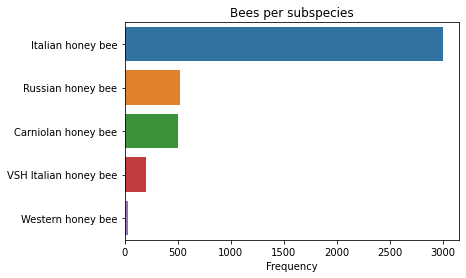

In [0]:
unmixed_labels_df = pd.DataFrame(unmixed_labels, columns = ['unmixed_labels'])
unmixed_subspecies_counts = unmixed_labels_df['unmixed_labels'].value_counts()
plt.title("Bees per subspecies")
g = sns.barplot(x = unmixed_subspecies_counts, y = unmixed_subspecies_counts.index)
g.set_xlabel("Frequency")

In [0]:
unmixed_le = LabelEncoder()
unmixed_encoded_labels = unmixed_le.fit_transform(unmixed_labels)
unmixed_y = to_categorical(unmixed_encoded_labels)

In [0]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(unmixed_encoded_labels), unmixed_encoded_labels)
class_weight_dict = dict(enumerate(class_weights))
sample_weights = class_weight.compute_sample_weight('balanced', unmixed_encoded_labels)
print("class_weights : {}\nclass_weights.shape: {}\nclass_weights_dict : {}\nsample_weights.shape : {}\ny.shape : {}"
        .format(class_weights, class_weights.shape, class_weight_dict, sample_weights.shape, unmixed_y.shape))

class_weights : [ 1.70538922  0.28404255  1.62125237  4.29346734 23.09189189]
class_weights.shape: (5,)
class_weights_dict : {0: 1.7053892215568862, 1: 0.28404255319148936, 2: 1.6212523719165086, 3: 4.293467336683417, 4: 23.09189189189189}
sample_weights.shape : (4272,)
y.shape : (4272, 5)


In [0]:
X_train, X_test, Y_train, Y_test, sample_weights_train, sample_weights_test = train_test_split(unmixed_reshaped_images, unmixed_y, sample_weights, test_size=0.2, random_state=2020)
print("X_train.shape = {}\nX_test.shape = {}\ny_train.shape = {}\ny_test.shape = {}\nsample_weights_train.shape = {}\nsample_weights_test.shape = {}"
      .format(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape,sample_weights_train.shape, sample_weights_test.shape))

X_train.shape = (3417, 64, 56, 3)
X_test.shape = (855, 64, 56, 3)
y_train.shape = (3417, 5)
y_test.shape = (855, 5)
sample_weights_train.shape = (3417,)
sample_weights_test.shape = (855,)


We need to refine CNN's architecture: in particular last **Dense** layer must have $5$ units instead of $6$, as we have just removed all the images belonging to **1 Mixed local stock 2** class. Furthermore, we need to refit *ImageDataGenerator* on the new dataset.



In [0]:
train_datagen.fit(X_train)

In [0]:
base_model = deepcopy(model_copy)
nb_classes = Y_train.shape[1]

base_model.pop()
base_model.add(Dense(
    nb_classes,
    activation='softmax',
    kernel_initializer="glorot_uniform",
    name='dense'
))
base_model.summary()

learning_rate = 0.0001
base_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate),
              metrics=['accuracy'])

dense5_model_copy = deepcopy(base_model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 64, 56, 32)        896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 64, 56, 32)        9248      
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 32, 28, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 32, 28, 32)        9248      
_________________________________________________________________
max_pool_3 (MaxPooling2D)    (None, 16, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7168)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                

In [0]:
n_epochs = 200
batch_size = 128

history = base_model.fit_generator(
    train_datagen.flow(x = X_train, y = Y_train, batch_size=batch_size, shuffle=True, sample_weight=sample_weights_train),
    validation_data = (X_test, Y_test, sample_weights_test),
    steps_per_epoch=ceil(len(X_train)/ batch_size),
    callbacks=[early_stopping],
    epochs=n_epochs,
    verbose = 1
)

serialize(base_model, os.path.join(s_directory, 'base_model.ser'))

Epoch 1/200
27/27 [==============================] - 4s 161ms/step - loss: 8.0718 - accuracy: 0.2871 - val_loss: 2.7586 - val_accuracy: 0.4819
Epoch 2/200
27/27 [==============================] - 4s 159ms/step - loss: 2.3933 - accuracy: 0.4835 - val_loss: 1.1676 - val_accuracy: 0.5380
Epoch 3/200
27/27 [==============================] - 4s 157ms/step - loss: 1.3804 - accuracy: 0.6064 - val_loss: 0.7643 - val_accuracy: 0.6421
Epoch 4/200
27/27 [==============================] - 4s 155ms/step - loss: 1.0419 - accuracy: 0.6860 - val_loss: 0.6515 - val_accuracy: 0.7310
Epoch 5/200
27/27 [==============================] - 4s 153ms/step - loss: 0.7988 - accuracy: 0.7351 - val_loss: 0.5061 - val_accuracy: 0.8526
Epoch 6/200
27/27 [==============================] - 4s 154ms/step - loss: 0.8145 - accuracy: 0.7392 - val_loss: 0.4682 - val_accuracy: 0.8678
Epoch 7/200
27/27 [==============================] - 4s 155ms/step - loss: 0.5653 - accuracy: 0.8025 - val_loss: 0.5605 - val_accuracy: 0.9111

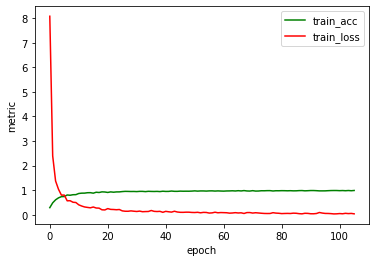

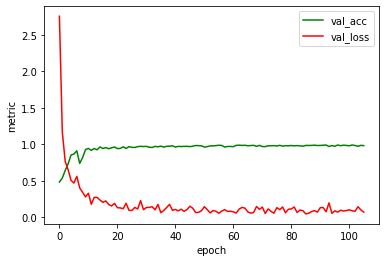

In [0]:
plot_acc_loss(history.history)

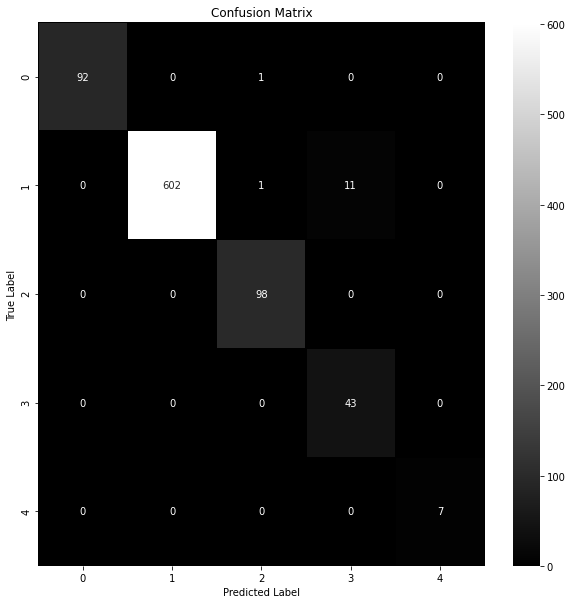

In [0]:
plot_confusion_matrix(base_model, X_test, Y_test)

We have just got an incredibly high accuracy measure on the validation set, that is about $98\%$. As we can observe from the confusion matrix above, this practically means that there are almost no mispredictions, especially for **Italian honey bee** images! Essentially, our assumption that **1 Mixed local stock 2** objects were confusing the CNN seems to be true. This might be due to images representing an **Italian honey bee** that are actually labeled as **1 Mixed local stock 2**. For this reason, **1 Mixed local stock 2** class is likely to be an alias for *unknown*, ending up being not only useless for all practical purposes but, most importantly, detrimental to the learning and classification process.

In the following, we are going to neglect it, especially in view of semi-supervised approach that is quite delicate.

# Applying semi-supervized learning to leverage unlabeled data and increase the size of the dataset

Differents types of semi-supervized learning techniques are available in literature. In the following, we will just describe the steps that characterize the method we are going to adopt, that are:

1. Training a model on labeled data such that it gives good results.
2. Employing it on unlabeled data to predict the outputs (i.e. *pseudo-labels*): we don’t know if these predictions are correct, but we do now have quite accurate labels (i.e. class predictions above a given confidence threshold) and that’s what we aim in this step.
3. Concatenating the actual labels to the *pseudo-labels*.
4. Concatenating the features of the labeled dataset set to the features of the unlabel dataset.
5. Trainng the model on this new dataset as in step 1.

For further details, read the [original paper](http://deeplearning.net/wp-content/uploads/2013/03/pseudo_label_final.pdf). [Here](https://arxiv.org/pdf/1704.03976.pdf)'s another semi-supervised learning technique not really useful in the present case.

In [0]:
def append_pseudo_labeled_images(labeled_images, labels, unlabeled_images, model, threshold = 0.9):
  """
   given a model, this function predicts the labels for unlabeled_images 
   and appends everything to the labeled dataset
   in order to increase the size of the training dataset
   @input:
   -labeled_images: ndarray of shape (n_labeled_images, width, height, n_channels)
   -labels: array of shape (n_labeled_images,) representing the label for those images
   -unlabeled_images: ndarray of shape (n_unlabeled_images, width, height, n_channels)
   -model: a CNN model to predict the labels for unlabeled_images
   -threshold: confidence threshold for pseudo-labels

   @returns
   -an ndarray of shape (n_labeled_images + n_unlabeled_images, width, height, n_channels)
   -an ndarray of the shape (n_labeled_images + n_unlabeled_images, n_classes) repsenting the labels of those images
  """
  
  pseudo_labels = model.predict_proba(unlabeled_images)
  '''
  # remove images predicted as Italian honey bees ptherwise they wil biased the distribution
  unlabeled_images = unlabeled_images[np.where(np.argmax(new_labels,axis=1) != 2)[0]] 
  new_labels = new_labels[np.where(np.argmax(new_labels,axis=1) != 2)[0]]
  '''
  good_predictions = np.where(np.max(pseudo_labels, axis=1) >= threshold)
  pseudo_labels = np.argmax(pseudo_labels[good_predictions], axis=1)
  unlabeled_images = unlabeled_images[good_predictions]

  labels_ext = np.append(np.argmax(labels, axis=1), pseudo_labels, axis=0)
  Y_train_ext =  to_categorical(labels_ext)
  X_train_ext = np.append(labeled_images, unlabeled_images, axis=0)
  return X_train_ext, Y_train_ext

Firstly, we load the [**PollenDataset**](https://github.com/piperod/PollenDataset) which contains bees labeled as *pollen bearing* or *non-pollen bearing*.

In [0]:
!unzip -q PollenDataset.zip
pollen_directory =  root_path+"pollen/"

In [0]:
import glob
img_list_1 = glob.glob(os.path.join(pollen_directory, '*.jpg'))
print("The number of new images is {%d}"%(len(img_list_1)))
unlabeled_images_1 = load_images("", img_list_1)

The number of new images is {714}


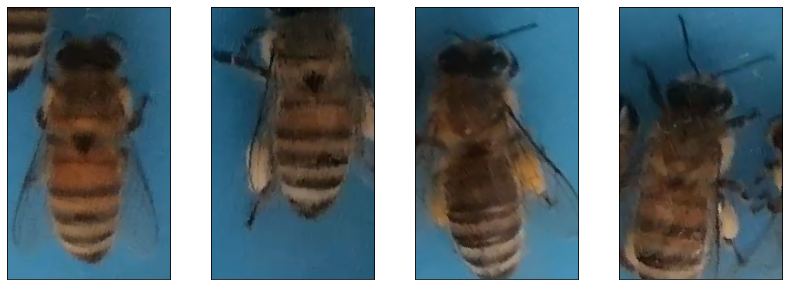

image number 661 has shape = (300, 180, 3)
image number 173 has shape = (300, 180, 3)
image number 118 has shape = (300, 180, 3)
image number 476 has shape = (300, 180, 3)
image number 707 has shape = (300, 180, 3)


In [0]:
show_images(unlabeled_images_1[:4])
show_image_shapes(unlabeled_images_1, 5)

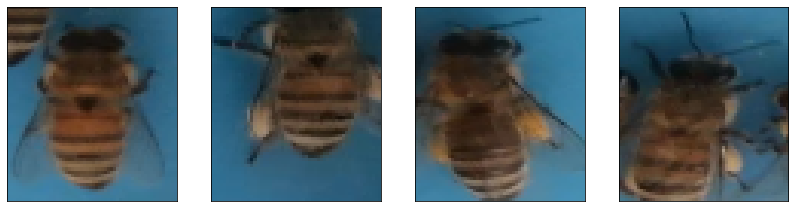

In [0]:
reshaped_unlabeled_images_1, new_shape = reshape_stretching_padding(unlabeled_images_1, ideal_height, ideal_width, 3, black_padding=False)
show_images(reshaped_unlabeled_images_1[:4])

In [0]:
'''
"base_model" is the model produced in "Restoring the original dataset but removing ambiguous images" section
There exist two different ways of obtaining "base_model":
  - deserializing a model contained in s_directory beloning to your Google Drive;
  - run "Restoring the original dataset but removing ambiguous images" section
'''
base_model = deserialize(os.path.join(s_directory, "base_model.ser"))
predictions_1 = np.argmax(base_model.predict(reshaped_unlabeled_images_1),axis=1)
print(predictions_1)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

As we can see here, such dataset apparently contains mostly **Italian honey bee** images.<br>
**NOTE**: We must point out that, while showing the predictions above, we are not taking into account any confidence threshold yet.

Now we append the newly imported dataset to the original training set.

In [0]:
'''
X_train and Y_train here are the dataset produced in "Restoring the original dataset but removing ambiguous images" section
In order to run this cell of code, you need to run the previous section of the notebook
'''
X_train_ext, Y_train_ext = append_pseudo_labeled_images(X_train, Y_train, reshaped_unlabeled_images_1, base_model, threshold=0.9)
print(X_train_ext.shape, Y_train_ext.shape)

(4131, 64, 56, 3) (4131, 5)


We have to refresh weights for each class and sample of the extended dataset.

In [0]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
ext_le = LabelEncoder()
Y_train_ext_labels = np.argmax(Y_train_ext, axis=1)
ext_encoded_labels = ext_le.fit_transform(Y_train_ext_labels)

In [0]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(ext_encoded_labels), ext_encoded_labels)
class_weight_dict = dict(enumerate(class_weights))
sample_weights_train = class_weight.compute_sample_weight('balanced', ext_encoded_labels)
print("class_weights : {}\nclass_weights.shape: {}\nclass_weights_dict : {}\nsample_weights_train.shape : {}\nY_train_ext.shape : {}"
        .format(class_weights, class_weights.shape, class_weight_dict, sample_weights_train.shape, Y_train_ext.shape))

class_weights : [ 2.025       0.26583012  1.92587413  5.29615385 27.54      ]
class_weights.shape: (5,)
class_weights_dict : {0: 2.025, 1: 0.26583011583011584, 2: 1.9258741258741259, 3: 5.296153846153846, 4: 27.54}
sample_weights_train.shape : (4131,)
Y_train_ext.shape : (4131, 5)


After having refit the *ImageDataGenerator*, eventually we can train the CNN on the new dataset.

In [0]:
train_datagen.fit(X_train_ext)
'''
If you are generating "after_pollen_model" from scratch, 
make sure you have created "dense5_model_copy" 
in "Restoring the original dataset but removing ambiguous images" section
'''
after_pollen_model = deepcopy(dense5_model_copy)

In [0]:
n_epochs = 100
batch_size = 128

history = after_pollen_model.fit_generator(
    train_datagen.flow(x = X_train_ext, y = Y_train_ext, batch_size=batch_size, shuffle=True, sample_weight=sample_weights_train),
    validation_data = (X_test, Y_test, sample_weights_test),
    steps_per_epoch=ceil(len(X_train_ext)/ batch_size),
    callbacks=[early_stopping],
    epochs=n_epochs,
    verbose = 1
)

serialize(after_pollen_model, os.path.join(s_directory, 'after_pollen_model.ser'))

Epoch 1/100
33/33 [==============================] - 5s 152ms/step - loss: 6.7446 - accuracy: 0.3394 - val_loss: 2.1319 - val_accuracy: 0.4772
Epoch 2/100
33/33 [==============================] - 5s 147ms/step - loss: 1.8546 - accuracy: 0.5727 - val_loss: 1.4682 - val_accuracy: 0.6456
Epoch 3/100
33/33 [==============================] - 5s 145ms/step - loss: 1.3045 - accuracy: 0.6350 - val_loss: 0.9983 - val_accuracy: 0.6795
Epoch 4/100
33/33 [==============================] - 5s 145ms/step - loss: 1.1092 - accuracy: 0.7052 - val_loss: 1.1614 - val_accuracy: 0.5415
Epoch 5/100
33/33 [==============================] - 5s 144ms/step - loss: 0.8326 - accuracy: 0.7252 - val_loss: 0.6311 - val_accuracy: 0.7006
Epoch 6/100
33/33 [==============================] - 5s 145ms/step - loss: 0.6212 - accuracy: 0.7935 - val_loss: 0.5678 - val_accuracy: 0.7614
Epoch 7/100
33/33 [==============================] - 5s 144ms/step - loss: 0.4758 - accuracy: 0.8211 - val_loss: 0.5840 - val_accuracy: 0.8409

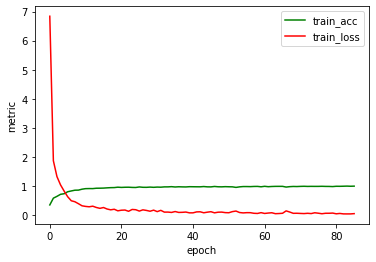

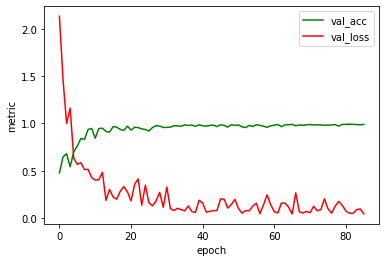

In [0]:
plot_acc_loss(history.history)

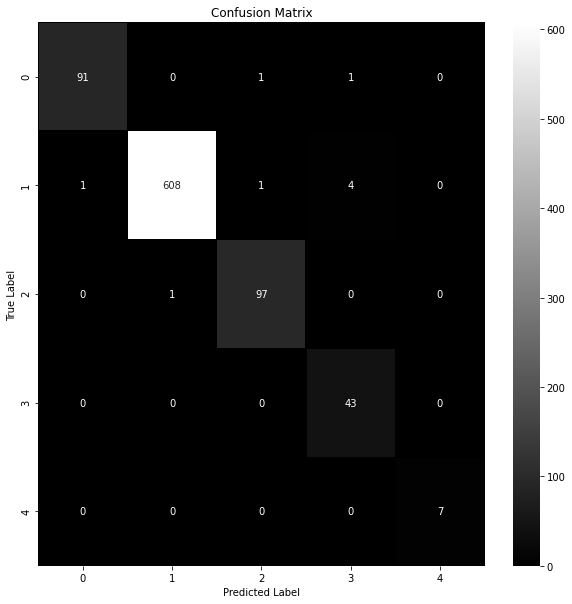

In [0]:
plot_confusion_matrix(model,X_test,Y_test)

Even if the dataset seems to contain only **Italian honey bee** images (with a probability $\approx 1$ for each of them), the CNN performed incredibly well and the misprediction ratio generally decreased. Therefore, we think it is safe to assume that this dataset could be very useful to improve CNN's performances. In the following, we are going to use the model trained on this extended dataset while infering further labels.

Now, we will go through the same steps as above with **Utah State University** datasets.

In [0]:
!unzip -q Utah.zip
utah_directory =  root_path+"Utah/"

In [0]:
import glob
img_list_2 = glob.glob(os.path.join(utah_directory, '**/*.png'), recursive=True)
print("The number of new images is {%d}"%(len(img_list_2)))
unlabeled_images_2 = load_images("", img_list_2)

The number of new images is {70645}


We can immeditately observe that the number of images included in this dataset is incredibily high compared to the original dataset ($7 \times 10^4 \gg  4 \times 10^3$).

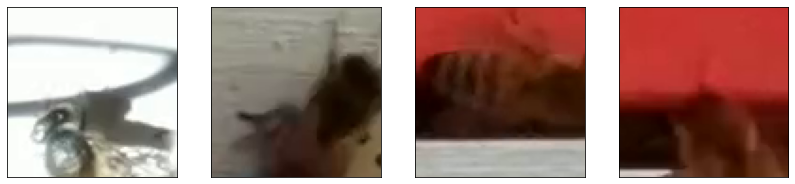

image number 50773 has shape = (32, 32, 3)
image number 46260 has shape = (32, 32, 3)
image number 40975 has shape = (90, 90, 3)
image number 65154 has shape = (32, 32, 3)
image number 54150 has shape = (32, 32, 3)


In [0]:
show_images(unlabeled_images_2[:4])
show_image_shapes(unlabeled_images_2, 5)

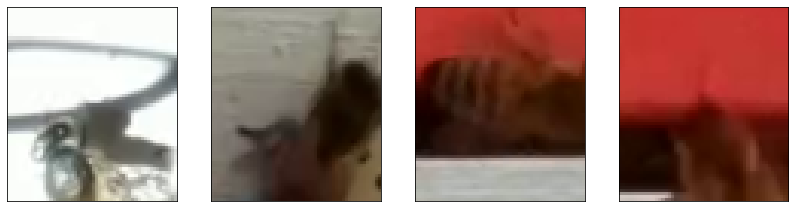

In [0]:
reshaped_unlabeled_images_2, new_shape = reshape_stretching_padding(unlabeled_images_2, ideal_height, ideal_width, 3, black_padding=False)
show_images(reshaped_unlabeled_images_2[:4])

In [0]:
'''
"after_pollen_model" is the model that you have just produced 
while performing semi-supervised learning on PollenDataset.
There exist two different ways of obtaining "after_pollen_model":
  - deserializing a model contained in s_directory beloning to your Google Drive;
  - run everything above in the current section.
'''
after_pollen_model = deserialize(os.path.join(s_directory, "after_pollen_model.ser"))
predictions_2 = np.argmax(after_pollen_model.predict(reshaped_unlabeled_images_2),axis=1)
print(predictions_2)

[2 1 1 ... 0 1 1]


This dataset seems to contains differents types of images, so it may be usefull to increase the training size.<br>
**NOTE**: We must point out that, while showing the predictions above, we are not taking into account any confidence threshold yet.

In [0]:
'''
X_train_ext and Y_train_ext here are the dataset above while extending X_train and Y_train with pseudo-labeled data
In order to run this cell of code, you need to generate these sets in the current section
'''
X_train_ext_2, Y_train_ext_2 = append_pseudo_labeled_images(X_train_ext, Y_train_ext, reshaped_unlabeled_images_2, after_pollen_model, threshold=1.0)
print(X_train_ext_2.shape, Y_train_ext_2.shape)

(54906, 64, 56, 3) (54906, 5)


In [0]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
ext_le_2 = LabelEncoder()
Y_train_ext_labels_2 = np.argmax(Y_train_ext_2, axis=1)
ext_encoded_labels_2 = ext_le_2.fit_transform(Y_train_ext_labels_2)

In [0]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(ext_encoded_labels_2), ext_encoded_labels_2)
class_weight_dict = dict(enumerate(class_weights))
sample_weights_train = class_weight.compute_sample_weight('balanced', ext_encoded_labels_2)
print("class_weights : {}\nclass_weights.shape: {}\nclass_weights_dict : {}\nsample_weights_train.shape : {}\nY_train_ext_2.shape : {}"
        .format(class_weights, class_weights.shape, class_weight_dict, sample_weights_train.shape, Y_train_ext_2.shape))

class_weights : [2.69147059e+01 2.03804681e-01 2.55972028e+01 6.95012658e+01
 3.66040000e+02]
class_weights.shape: (5,)
class_weights_dict : {0: 26.91470588235294, 1: 0.2038046806852137, 2: 25.597202797202797, 3: 69.50126582278482, 4: 366.04}
sample_weights_train.shape : (54906,)
Y_train_ext_2.shape : (54906, 5)


As we may notice class distribution changed quite a lot, especially in favour of **Italian honey bee** class.

In [0]:
train_datagen.fit(X_train_ext_2)
model = deepcopy(dense5_model_copy)

learning_rate = 0.0001
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate),
              metrics=['accuracy'])

In [0]:
n_epochs = 200
batch_size = 4096

history = model.fit_generator(
    train_datagen.flow(x = X_train_ext_2, y = Y_train_ext_2, batch_size=batch_size, shuffle=True, sample_weight=sample_weights_train),
    validation_data = (X_test, Y_test, sample_weights_test),
    steps_per_epoch=ceil(len(X_train_ext_2)/ batch_size),
    callbacks=[early_stopping],
    epochs=n_epochs,
    verbose = 1
)

serialize(model, os.path.join(s_directory, 'after_utah_model.ser'))

Epoch 1/200
14/14 [==============================] - 64s 5s/step - loss: 10.8530 - accuracy: 0.2358 - val_loss: 6.1606 - val_accuracy: 0.2386
Epoch 2/200
14/14 [==============================] - 62s 4s/step - loss: 4.6940 - accuracy: 0.4079 - val_loss: 3.3079 - val_accuracy: 0.4433
Epoch 3/200
14/14 [==============================] - 63s 4s/step - loss: 2.1814 - accuracy: 0.6102 - val_loss: 2.3441 - val_accuracy: 0.3930
Epoch 4/200
14/14 [==============================] - 62s 4s/step - loss: 1.4091 - accuracy: 0.6516 - val_loss: 1.9074 - val_accuracy: 0.4409
Epoch 5/200
14/14 [==============================] - 62s 4s/step - loss: 1.0139 - accuracy: 0.7317 - val_loss: 1.5730 - val_accuracy: 0.5333
Epoch 6/200
14/14 [==============================] - 61s 4s/step - loss: 0.7590 - accuracy: 0.7936 - val_loss: 1.2862 - val_accuracy: 0.5637
Epoch 7/200
14/14 [==============================] - 62s 4s/step - loss: 0.5622 - accuracy: 0.8289 - val_loss: 1.2271 - val_accuracy: 0.5649
Epoch 8/200


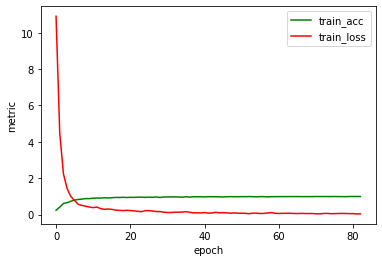

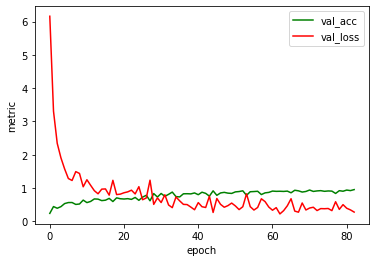

In [0]:
plot_acc_loss(history.history)

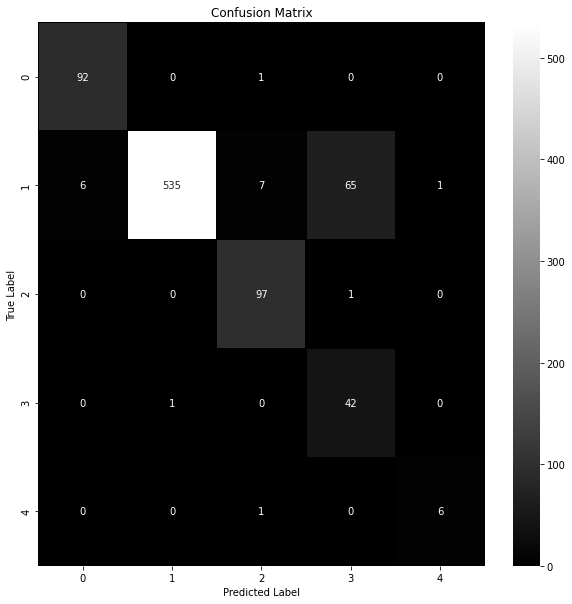

In [0]:
plot_confusion_matrix(model,X_test,Y_test)

We may highlight that performances got worse after the last learning task, especially for **Italian honey bee** images predicted to be **VSH Italian honey bee**. Indeed, even if we are infering *pseudo-labels* strictly bounded by $100 \%$ probability as confidence threshold, the CNN might stop learning due to:

* its architecture, which now may need to be refined;
* poor quality of the images included in **Utah State University** dataset;
* **VSH Italian honey bee** images, which might be highly correlated to **Italian honey bee** ones, as previous tasks showed too.

#Try to apply transfer Learning using VGG16

[official documentation](https://keras.io/applications/#vgg16)

[original paper](https://arxiv.org/abs/1409.1556)

In [0]:
from keras.applications import VGG16

base_model = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape= new_shape, pooling=None, classes=1000)

58892288/58889256 [==============================] - 2s 0us/step


In [0]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(nb_classes,activation='softmax')(x) #final layer with softmax activation

In [0]:
model=Model(inputs=base_model.input,outputs=preds)

####check the architechture of the define model

In [0]:
for i,layer in enumerate(model.layers):
  print(i,layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_average_pooling2d_1
20 dense_1
21 dense_2
22 dense_3
23 dense_4


###Set trainable flag of convolutional layers to false

In [0]:
for layer in model.layers[:20]:
    layer.trainable=False

In [0]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
n_epochs = 30
batch_size = 64

history = model.fit_generator(
    train_datagen.flow(x= X_train_new, y = Y_train_new, batch_size=batch_size, shuffle=True),
    validation_data = (X_test, Y_test),
    steps_per_epoch=ceil(len(X_train)/ batch_size),
    epochs=n_epochs,
    verbose = 1
)

Epoch 1/30
28/28 [==============================] - 3s 120ms/step - loss: 3.2975 - accuracy: 0.5843 - val_loss: 0.5262 - val_accuracy: 0.8139
Epoch 2/30
28/28 [==============================] - 2s 84ms/step - loss: 0.5407 - accuracy: 0.8022 - val_loss: 0.4915 - val_accuracy: 0.8139
Epoch 3/30
28/28 [==============================] - 2s 82ms/step - loss: 0.4817 - accuracy: 0.8185 - val_loss: 0.3315 - val_accuracy: 0.8834
Epoch 4/30
28/28 [==============================] - 2s 81ms/step - loss: 0.3878 - accuracy: 0.8577 - val_loss: 0.3176 - val_accuracy: 0.8655
Epoch 5/30
28/28 [==============================] - 2s 79ms/step - loss: 0.3865 - accuracy: 0.8532 - val_loss: 0.3447 - val_accuracy: 0.8901
Epoch 6/30
28/28 [==============================] - 3s 93ms/step - loss: 0.3645 - accuracy: 0.8655 - val_loss: 0.2892 - val_accuracy: 0.8946
Epoch 7/30
28/28 [==============================] - 2s 77ms/step - loss: 0.3169 - accuracy: 0.8867 - val_loss: 0.2606 - val_accuracy: 0.8924
Epoch 8/30
2

In [0]:
plot_acc_loss(history.history)

In [0]:
plot_confusion_matrix(model, X_test, Y_test)

NOTE: When we freeze the weigths of the CNN layers and train only the ones of the dense layers, the performances achieved by VGG16 network are quite similar to the one obtained with our basic network. However, this network have some advantages because it's easier to train(less trainable parmeters).